# Прогнозирование уровня средней заработной платы в России

Известны данные о заработной плате за каждый месяц с января 1993 по август 2016. Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [1]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def inv_box_cox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Загрузка данных.

In [4]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [5]:
data.columns = ['wage']

In [6]:
data.head()

,wage
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [7]:
data.describe()

,wage
count,284.000000
mean,12193.308099
std,11992.326701
min,15.300000
25%,1191.000000
50%,7195.000000
75%,21365.250000
max,43408.000000


## Визуальный анализ ряда

 Строим график:

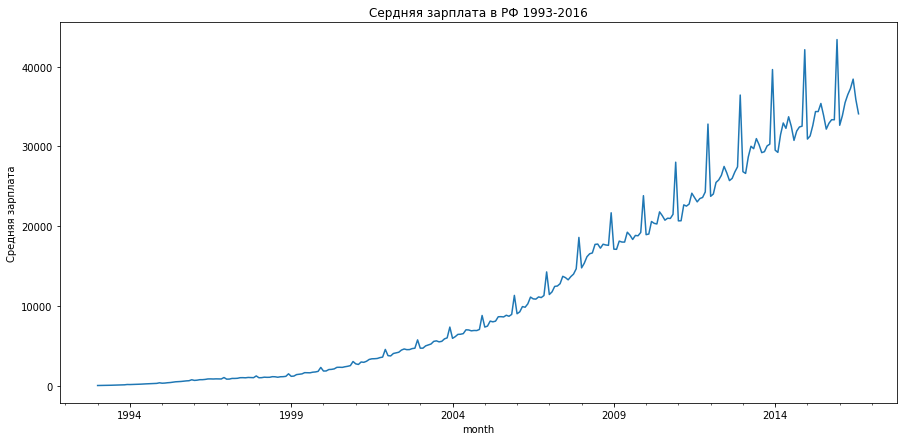

In [9]:
plt.figure(figsize(15,7))
data.wage.plot()
plt.ylabel(u"Средняя зарплата")
plt.title(u"Сердняя зарплата в РФ 1993-2016")
pylab.show()

STL-декомпозиция:

Дики-Фуллера критерий: p=0.991850


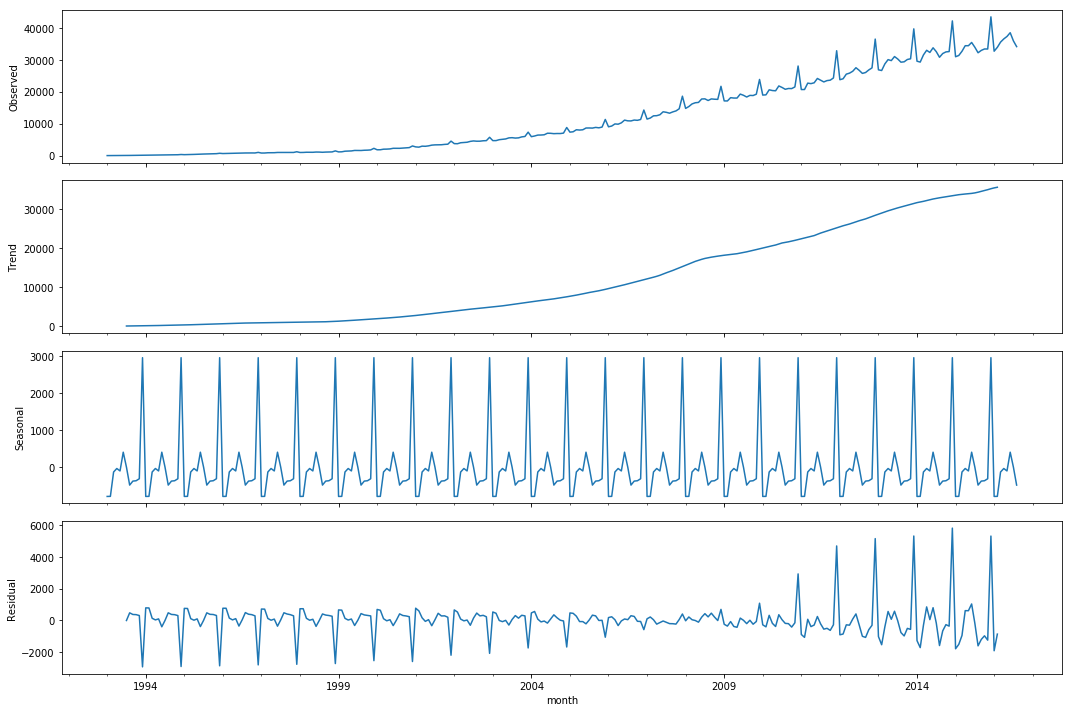

In [10]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage).plot()
print("Дики-Фуллера критерий: p=%f" % sm.tsa.stattools.adfuller(data.wage)[1])

Гипотеза о стационарности отвергается, так как критерий Дики Фуллера выше 0.05

## Стабилизация дисперсии

Применим преобразование Бокса-Кокса:

Параметр преобразования Бокса-Кокса: 0.263202
Дики-Фуллера: p=0.696899


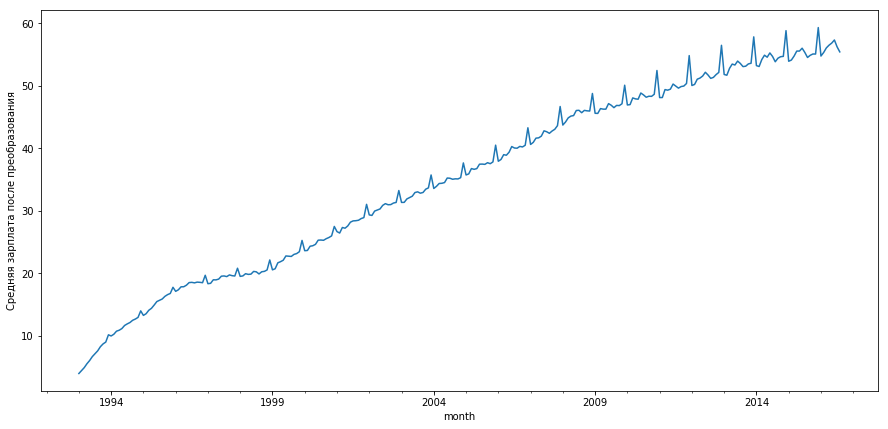

In [11]:
data['wage_box'], lymbda = stats.boxcox(data.wage)
plt.figure(figsize(15,7))
data.wage_box.plot()
plt.ylabel(u'Средняя зарплата после преобразования')
print("Параметр преобразования Бокса-Кокса: %f" % lymbda)
print("Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box)[1])

## Стационарность

Применим сезонное дифференцирование:

Дики-Фуллера: p=0.014697


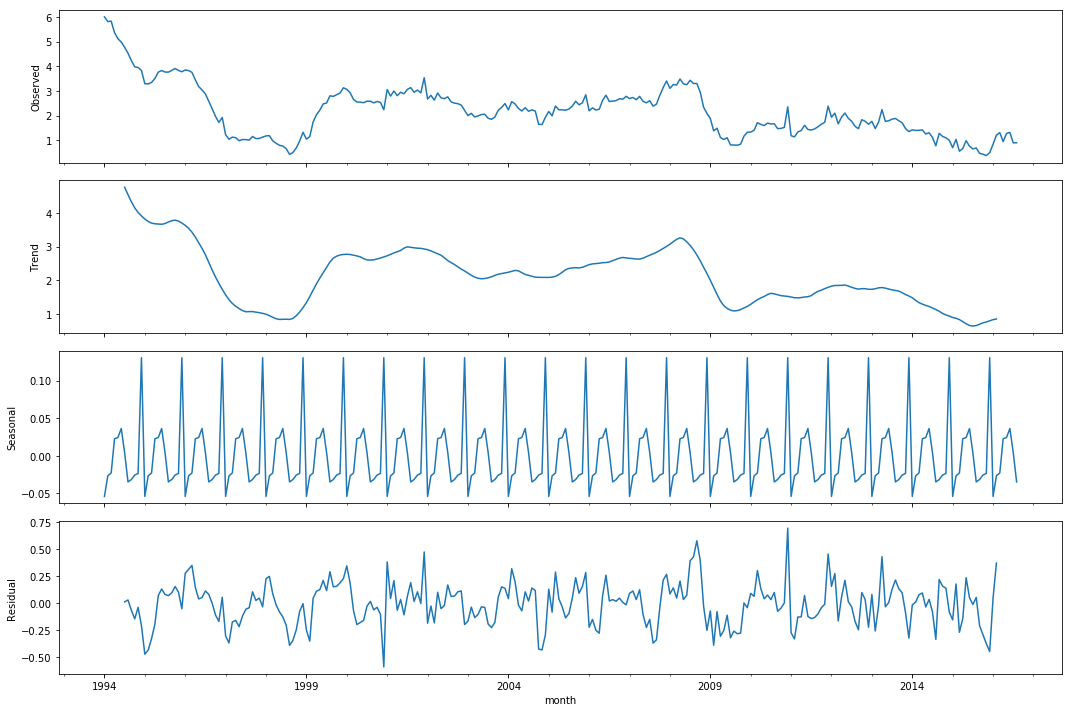

In [13]:
data['wage_box_diff'] = data.wage_box - data.wage_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box_diff[12:]).plot()
print("Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box_diff[12:])[1])

Применим обычное дифференцирование:

Дики-Фуллера: p=0.000000


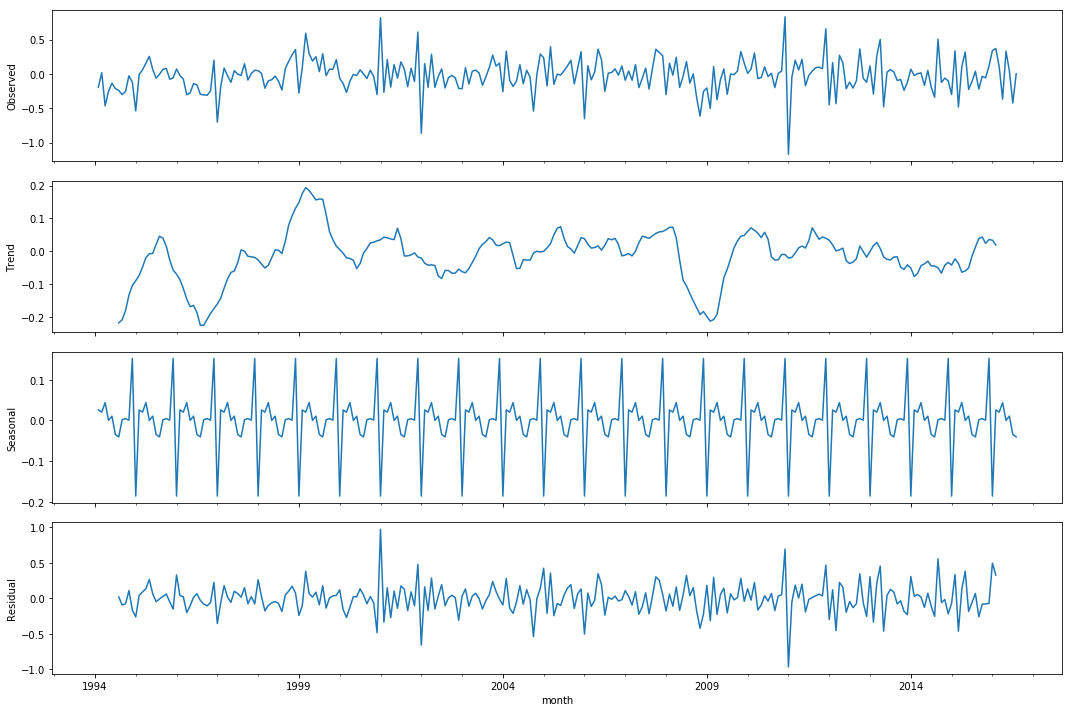

In [14]:
data['wage_box_diff2'] = data.wage_box_diff - data.wage_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box_diff2[13:]).plot()
print("Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box_diff2[13:])[1])

Теперь мы плучили стационарный ряд

## Обучение и сравнение моделей-кандидатов

Состроим графики автокорреляции:

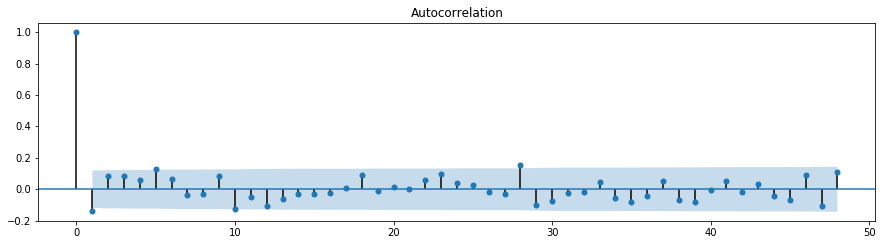

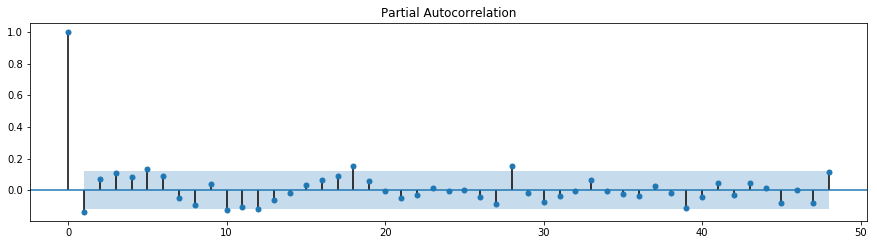

In [15]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

анализируя графики возьмем следующие начальные приближения: Q=0, q=1, P=1, p=1.

In [23]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [26]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("длина массива параметров: "+str(len(parameters_list)))

длина массива параметров: 8


In [36]:
results = []
better_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.wage_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < better_aic:
        better_model = model
        better_aic = aic
        better_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print('______________________')
print('\n')
print('better model: ')
print(better_model.summary())

     parameters       aic
4  (1, 0, 1, 0)  0.340521
2  (0, 1, 1, 0)  1.170768
6  (1, 1, 1, 0)  2.021911
3  (1, 0, 0, 0)  2.625709
1  (0, 1, 0, 0)  3.369832
______________________


better model: 
                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Sun, 03 Dec 2017   AIC                              0.341
Time:                                    20:07:51   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.97

Построим график

Критерий Стьюдента: 0.090787
Критерий Дики-Фуллера: 0.000003


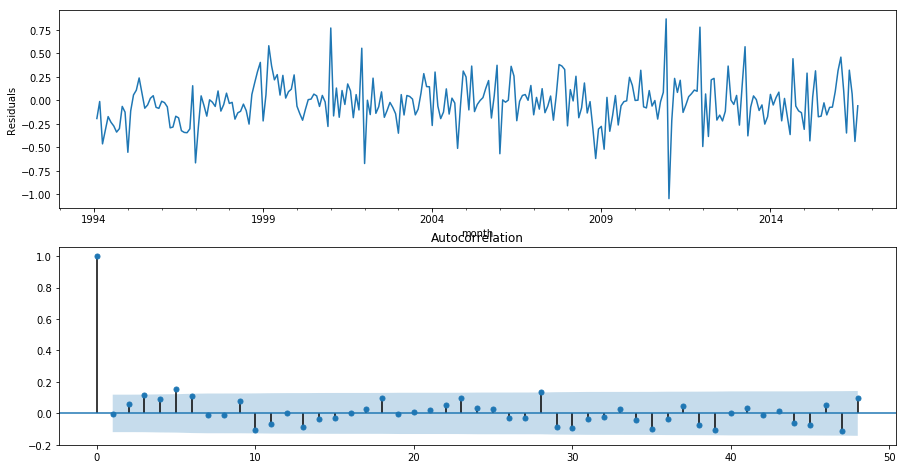

In [37]:
plt.figure(figsize(15,8))
plt.subplot(211)
better_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(better_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: %f" % stats.ttest_1samp(better_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: %f" % sm.tsa.stattools.adfuller(better_model.resid[13:])[1])

Строим график по модели:

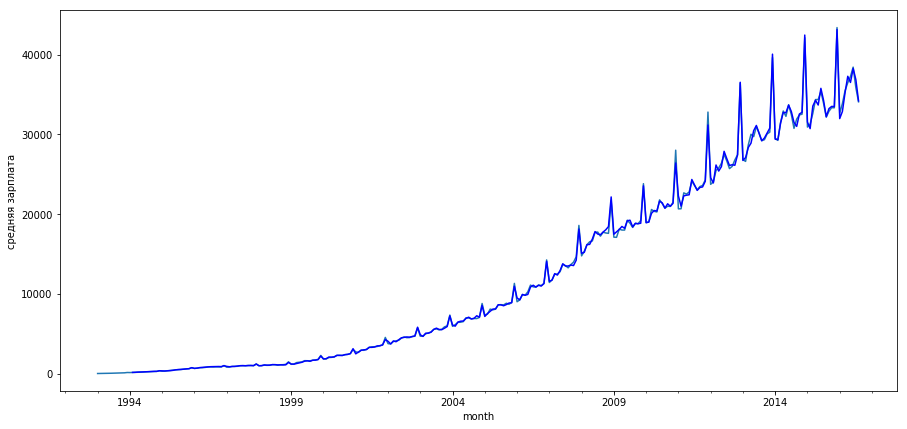

In [41]:
data['model'] = inv_box_cox(better_model.fittedvalues, lymbda)
plt.figure(figsize(15,7))
data.wage.plot()
data.model[13:].plot(color='b')
plt.ylabel(u'средняя зарплата')
pylab.show()

## Прогнозирование с помощью финальной модели

Строим график прогноза заработной платы:

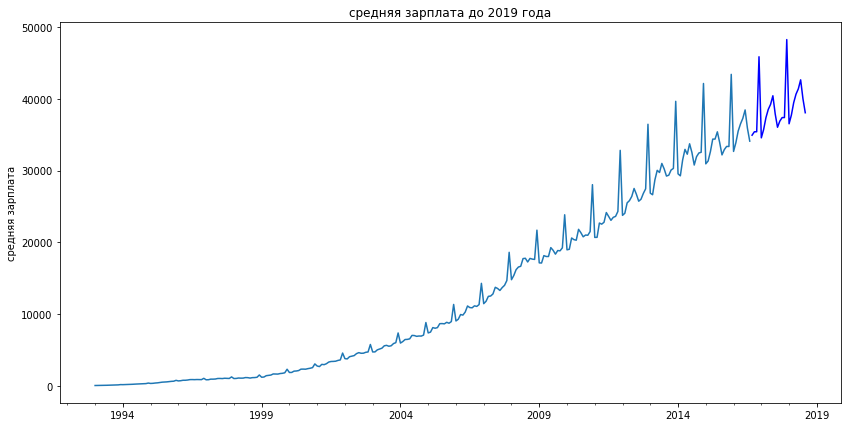

In [45]:
data_1 = data[['wage']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
for_2019 = pd.DataFrame(index=date_list, columns= data_1.columns)
data_1 = pd.concat([data_1, for_2019])
data_1['forecast'] = inv_box_cox(better_model.predict(start=284, end=308), lymbda)

plt.figure(figsize(14,7))
data_1.forecast.plot(color='blue')
plt.ylabel(u'средняя зарплата')
plt.title(u'средняя зарплата до 2019 года')
data_1.wage.plot()
pylab.show()

Прогноз соотносится с предыдущими показателями